# Softmax实践（图像分类数据集）

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from d2l import torch as d2l

引入并下载Fashion-MINIS数据集

In [7]:
mnist_train = torchvision.datasets.FashionMNIST(root = './data', train= True, 
                                                transform=transforms.ToTensor(), download=True)
mnist_test = torchvision.datasets.FashionMNIST(root = './data', train= False,
                                                transform=transforms.ToTensor(), download=True)
print(mnist_train.__len__(), mnist_test.__len__())
mnist_train[0][0].shape # 单通道28*28的图像

60000 10000


torch.Size([1, 28, 28])

Fashion-MNIST数据集包含了10个类别的灰度图片，可以通过以下函数来实现将数字索引转换为字符类别：

In [9]:
def get_fashion_mnist_labels(labels):
    """Return text labels for the Fashion-MNIST dataset."""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

创建函数可视化样本：

In [10]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

In [14]:
X,y = next(iter(DataLoader(mnist_train, batch_size= 18)))
# X,y = DataLoader(mnist_train, batch_size= 18)[0]
show_images(X.reshape(18,28,28), 2 ,9 , titles=get_fashion_mnist_labels(y))

array([<Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'dress'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'trouser'}>,
       <Axes: title={'center': 't-shirt'}>], dtype=object)

## 读取小批量

In [ ]:
batch_size = 256
def get_dataloader_works():
    return 4

train_iter = DataLoader(mnist_train, batch_size, shuffle=True , num_workers=get_dataloader_works())

看一下读取训练数据所需的时间

In [18]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'1.84 sec'

得到一个汇总的load_data函数，用于获取和读取Fashion-MNIST数据集，该函数返回训练集和验证集的数据迭代器，并可以接收`resize`选项

In [19]:
def loat_data_fashion_mnist(batch_size , resize = None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root = './data', train= True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root = './data', train= False, transform=trans, download=True)
    num_workers = get_dataloader_works()
    train_iter = DataLoader(mnist_train, batch_size, shuffle=True , num_workers=num_workers)
    test_iter = DataLoader(mnist_test, batch_size, shuffle=False , num_workers=num_workers)
    return train_iter, test_iter

In [32]:
# 测试函数的图像大小调整能力
tran_iter , test_iter = loat_data_fashion_mnist(32)
for X, y in tran_iter:
    print(X.shape, y.shape)
    break

torch.Size([32, 1, 28, 28]) torch.Size([32])


# Softmax 从零实现

In [22]:
import torch
from IPython import display

batch_size = 256
train_iter , test_iter = loat_data_fashion_mnist(batch_size)

由于原始数据集中的乜咯赝本都是28×28的图像，所以在单纯的Softmax实现中，只能将其展平尾一个784维度的向量作为输入，而输出则是一个维度为10的向量

因此，**权重**将构成一个`784 x 10`的矩阵，**偏置**将构成一个`1 x 10`的向量。同样使用正态分布初始化权重W，偏置初始化为0

In [23]:
num_inputs = 784
num_outputs = 10
W = torch.normal(0 , 0.01 , size=(num_inputs , num_outputs), requires_grad = True)
b = torch.zeros(num_outputs , requires_grad= True)

Softmax本质上由三个步骤组成：
- 对每个项求幂
- 对每一行求和（小批量中每个样本是一行），得到每个样本的规范化常数
- 将每一行除以其规范化常数，确保结果的和为1
也即：
$$
\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(\mathbf{X}_{ij})}{\sum_k \exp(\mathbf{X}_{ik})}.
$$

In [24]:
def sofrmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(dim= 1, keepdim=True)
    return X_exp / partition  # 这里的X_exp和partition都是小批量中每个样本的一行

***定义模型***

In [25]:
def net(X):
    return sofrmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

***定义损失函数***

In [26]:
# 只需要一行代码就可以实现交叉熵
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

*关于这部分索引的实验性代码：*

In [ ]:
forward = net(X[0])
print(forward.shape)
a = [range(len(forward)), y[0]] # 需要确保y[0]的长度与forward的第一维长度相同
print(forward[a])

torch.Size([1, 10])
tensor([0.1089], grad_fn=<IndexBackward0>)


***分类精度***

In [47]:
def accuracy(y_hat , y):
    """计算分类准确率"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        # 获取每行的最大值索引,可以理解为消融掉列方向的自由度，结果为一个列向量
        y_hat = y_hat.argmax(axis=1)  
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

至此，可以构造一个数据评估器，对于任意的数据迭代器，都可以评估任意模型在其上运行的精度

In [48]:
def evaluate_accuracy(net , data_iter):
    if isinstance(net, torch.nn.Module):    # 如果net是torch的Module类型
        net.eval()
    metric = d2l.Accumulator(2) # 正确预测数, 总预测数
    with torch.no_grad():
        for X,y in data_iter:
            # accuracy返回的是当前批次中正确预测的数量，y.numel()是当前批次的样本数量
            metric.add(accuracy(net(X) , y), y.numel())
    return metric[0] / metric[1]
    

测试evaluate函数

In [49]:
evaluate_accuracy(net , test_iter)

0.1332

### 训练

In [51]:
def train_epoch_ch3(net, train_iter, loss, updater):  
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = d2l.Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

在展示训练函数的实现之前，我们[**定义一个在动画中绘制数据的实用程序类**]`Animator`，
它能够简化本书其余部分的代码。

In [52]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

### 定义训练函数

In [53]:
def train_ch3(net , train_iter, test_iter ,loss, num_epochs , updater):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [55]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

In [56]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

### 预测

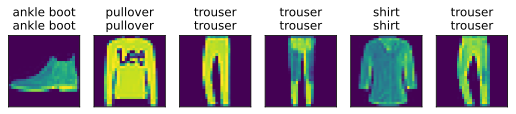

In [57]:
def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)